# Our primary task is to develop a classification model or generative AI application to distinguish between legitimate (non-spam) and spam messages.

## I propose three approaches to develop our spam detection model.
   1. Traditional machine learning classification models
       *   Logistic Regression
       *   Random Forest
       *   XGBoost
       *   Stacked Classifier

   2. Deep Learning technique
       *   RNNs : LSTM model
    
   3. Large Language Models
       *   RoBERTa : BERT-like LLM
       *   MistralAI : GenAI LLM 7B parameters

## In this notebook, I will explore the Large Language Model approach. In previous notebook we discussed plain MistralAI and finetuned MistralAI models. In this notebook, we will implement few shot learning method inetgrated with RAG for developing our Smap detection model. I have used NVIDIA V100 GPU runtime for this.

In few shot learning we provide a few examples of messages and thier categories along with the prompt. This way model can use these examples to classify the new message. But instead of keeping examples static we can impelement RAG to find similar examples from vector store and then provide these examples along with the prompts.

In [ ]:
#Install necessary libraries and packages
!pip -q install langchain tiktoken chromadb pypdf transformers InstructorEmbedding
!pip -q install accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.6/508.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Import AutoConfig class of Auto to check the configurations of the model
from transformers import AutoConfig
#Use from_pretrained method of Autoclass to load the config
config = AutoConfig.from_pretrained('mistralai/Mistral-7B-Instruct-v0.1')


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
#Import the BitsAndBytesConfig library to simplify the process of model quantization

from transformers import BitsAndBytesConfig
import torch

#Use the 4-bit quantization to reduce the memory usage by approximately fourfold
#Change compute data type to torch.bfloat16 to improve the speed

bnb_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_compute_dtype=torch.bfloat16)

In [ ]:
import torch
import transformers

# Import AutoModelForCasualLM as Mistral has CausalLm configuration class

from transformers import AutoTokenizer, AutoModelForCausalLM

#Setup tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

# Load pre-trained Mistral model for causal language modeling
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1",
                                              quantization_config=bnb_config,
                                              device_map='auto',
                                              low_cpu_mem_usage=True)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
import torch

#Choose the text-generation pipeline for Mistral model, passing in the model and tokenizer
#Choose hyperparameters of the model

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=20,
    temperature=0.5,
    top_p=0.95,
    do_sample=True)

#Create an instance of the model using created pipeline
local_llm = HuggingFacePipeline(pipeline=pipe)

In [ ]:
#Sample question to check if model and pipeline is working
print(local_llm('What is the capital of England?'))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




London is the capital city of England.


In [ ]:
import os
#Import Chroma vector store from langchain
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

#Import DirectoryLoader and PyPDFLoader to load pdf files from the given folder
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install sentence_transformers

#Instead of using OpenAIembeddings I have chosen open source InstructEmbedding model to calculate the embeddings of documents
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=3853c27667b86635cc89d65dce07e3f5c5844c8930b4e01c55b6a444b0a01477
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
from langchain.document_loaders.csv_loader import CSVLoader

In [ ]:
import pandas as pd
train_dataset=pd.read_csv("train_data.csv")


In [ ]:
train_dataset['flag'] = train_dataset['flag'].map({0: 'this message is ham', 1: 'this message is spam'})


In [ ]:
import pandas as pd



# Create a new column 'combined' containing dictionaries
train_dataset['combined'] = train_dataset.apply(lambda row: {'message': row['message'], 'category': row['flag']}, axis=1)

# Display the DataFrame
print(train_dataset["combined"].iloc[0])

{'message': '"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."', 'category': 'this message is ham'}


In [ ]:
train_dataset["combined"].to_csv("train_rag.csv")

In [ ]:
loader = CSVLoader(file_path="train_rag.csv", source_column="combined")

data = loader.load()

In [ ]:
#Import opensource hkunlp/instructor-xl embedding model
from langchain.embeddings import HuggingFaceInstructEmbeddings

instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl",
                                                      model_kwargs={"device": "cuda"})


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
# Embed chunks using embedding model and store the embeddings to chroma vector store
# Supplying a persist_directory will store the embeddings on disk
persist_directory = 'db'

## Create an instance of embedding model
embedding = instructor_embeddings

## Create a chroma vector database and store the embeddings
vectordb = Chroma.from_documents(documents=data,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

In [ ]:
# Create a retreiver to retreive relevant chunks from vector database.
#Provide the number of relevant chunks you would like to retreive. Here I have chosen three chunks.
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

In [ ]:
#Create a prompt template
from langchain.prompts import PromptTemplate
prompt_template = """
I have received a message. I want to identify whether it's a spam or ham.
I will provide a few examples of messages and thier categories for your reference.
{context}

Message I received: {question}
cateogry:
"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

In [ ]:
#Create the chain to answer questions
#Provide the components we built so far to the chain
#Provide LLM to generate the text using context
#Provide retreiver to retreive context from vector database
#Choose to return context/Source documents

chain_type_kwargs = {"prompt": PROMPT}
qa_chain = RetrievalQA.from_chain_type(llm=local_llm,
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True,
                                  chain_type_kwargs=chain_type_kwargs)

In [ ]:
import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):

    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])
        return(source.metadata['source'])

In [ ]:
test_dataset=pd.read_csv("test_data.csv")

In [ ]:
print(test_dataset["message"].iloc[4])

Have you emigrated or something? Ok maybe 5.30 was a bit hopeful...


In [ ]:
#Evaluate our few shot learning+RAG approach on test data
y_pred=[]
for i in range(len(test_dataset)):
  print(i)
  query = test_dataset["message"].iloc[i]
  llm_response = qa_chain(query)
  answer=process_llm_response(llm_response)
  y_pred.append(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


0


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 104, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Probably a couple hours tops', 'category': 'this message is ham'}
1


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 169, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..', 'category': 'this message is ham'}
2


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'YO YO YO BYATCH WHASSUP?', 'category': 'this message is ham'}
3


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Jane babes not goin 2 wrk, feel ill after lst nite. Foned in already cover 4 me chuck.:-)"', 'category': 'this message is ham'}
4


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No. Its not specialisation. Can work but its slave labor. Will look for it this month sha cos no shakara 4 beggar.', 'category': 'this message is ham'}
5


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 98, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nothing much, chillin at home. Any super bowl plan?"', 'category': 'this message is ham'}
6


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 90, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Sent me ur email id soon', 'category': 'this message is ham'}
7


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 138, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Guess who am I?This is the first time I created a web page WWW.ASJESUS.COM read all I wrote. I'm waiting for your opinions. I want to be your friend 1/1", 'category': 'this message is spam'}
8


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 130, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Ok then i'll let him noe later n ask him call u tmr...", 'category': 'this message is ham'}
9


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 187, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"And that is the problem. You walk around in \\julianaland\\"" oblivious to what is going on around you. I say the same things constantly and they go in one ear and out the other while you go off doing whatever you want to do. It\'s not that you don\'t know why I\'m upset--it\'s that you don\'t listen when i tell you WHAT is going to upset me. Then you want to be surprised when I\'m mad."""', 'category': 'this message is ham'}
10


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 98, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ok.ok ok..then..whats ur todays plan', 'category': 'this message is ham'}
11


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Have a safe trip to Nigeria. Wish you happiness and very soon company to share moments with', 'category': 'this message is ham'}
12


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Now got tv 2 watch meh? U no work today?', 'category': 'this message is ham'}
13


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 114, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'it to 80488. Your 500 free text messages are valid until 31 December 2005.', 'category': 'this message is spam'}
14


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Prabha..i'm soryda..realy..frm heart i'm sory", 'category': 'this message is ham'}
15


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 126, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Goodmorning, today i am late for 2hrs. Because of back pain."', 'category': 'this message is ham'}
16


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 171, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Havent mus ask if u can 1st wat. Of meet 4 lunch den u n him meet can already lor. Or u wan 2 go ask da ge 1st then confirm w me asap?', 'category': 'this message is ham'}
17


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Oh dang! I didn't mean o send that to you! Lol!", 'category': 'this message is ham'}
18


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 135, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ha... Both of us doing e same thing. But i got tv 2 watch. U can thk of where 2 go tonight or u already haf smth in mind...', 'category': 'this message is ham'}
19


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 120, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Okey doke. I\'m at home, but not dressed cos laying around ill! Speak to you later bout times and stuff. "', 'category': 'this message is ham'}
20


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed", 'category': 'this message is ham'}
21


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Sorry my roommates took forever, it ok if I come by now?"', 'category': 'this message is ham'}
22


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 195, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"HELLOGORGEOUS, HOWS U? MY FONE WAS ON CHARGE LST NITW WEN U TEXD ME. HOPEU AD A NICE WKEND AS IM SURE U DID LOOKIN 4WARD 2 C-IN U 2MRW LUV JAZ"', 'category': 'this message is ham'}
23


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 158, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good afternoon sexy buns! How goes the job search ? I wake and you are my first thought as always, my love. I wish your fine and happy and know I adore you!"', 'category': 'this message is ham'}
24


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 110, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Badrith is only for chennai:)i will surely pick for us:)no competition for him.', 'category': 'this message is ham'}
25


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 165, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Are you happy baby ? Are you alright ? Did you take that job ? I hope your fine. I send you a kiss to make you smile from across the sea ... *kiss* *kiss*', 'category': 'this message is ham'}
26


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 117, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Nope i'm not drivin... I neva develop da photos lei...", 'category': 'this message is ham'}
27


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 143, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your weekly Cool-Mob tones are ready to download !This weeks new Tones include: 1) Crazy Frog-AXEL F>>> 2) Akon-Lonely>>> 3) Black Eyed-Dont P >>>More info in n', 'category': 'this message is spam'}
28


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'How u doin baby girl ?? hope u are okay every time I call ure phone is off! I miss u get in touch', 'category': 'this message is ham'}
29


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Sounds like a plan! Cardiff is still here and still cold! I'm sitting on the radiator!", 'category': 'this message is ham'}
30


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 134, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Havent mus ask if u can 1st wat. Of meet 4 lunch den u n him meet can already lor. Or u wan 2 go ask da ge 1st then confirm w me asap?', 'category': 'this message is ham'}
31


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'A pure hearted person can have a wonderful smile that makes even his/her enemies to feel guilty for being an enemy.. So catch the world with your smile..:) GOODMORNING &amp; HAVE A SMILEY SUNDAY..:)', 'category': 'this message is ham'}
32


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 104, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dont pick up d call when something important is There to tell. Hrishi', 'category': 'this message is ham'}
33


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.", 'category': 'this message is ham'}
34


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'What to think no one saying clearly. Ok leave no need to ask her. I will go if she come or not', 'category': 'this message is ham'}
35


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 129, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Even u dont get in trouble while convincing..just tel him once or twice and just tel neglect his msgs dont c and read it..just dont reply', 'category': 'this message is ham'}
36


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'K..then come wenever u lik to come and also tel vikky to come by getting free time..:-)', 'category': 'this message is ham'}
37


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I think it's all still in my car", 'category': 'this message is ham'}
38


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"A famous quote : when you develop the ability to listen to \'anything\' unconditionally without losing your temper or self confidence, it means you are ......... \'MARRIED\'"', 'category': 'this message is ham'}
39


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 106, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Yup i thk so until e shop closes lor.', 'category': 'this message is ham'}
40


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Just chill for another 6hrs. If you could sleep the pain is not a surgical emergency so see how it unfolds. Okay', 'category': 'this message is ham'}
41


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 97, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Haha awesome, be there in a minute"', 'category': 'this message is ham'}
42


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Think I could stop by in like an hour or so? My roommate's looking to stock up for a trip", 'category': 'this message is ham'}
43


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Did u find a sitter for kaitlyn? I was sick and slept all day yesterday.', 'category': 'this message is ham'}
44


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 130, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"All done, all handed in. Don\'t know if mega shop in asda counts as celebration but thats what i\'m doing!"', 'category': 'this message is ham'}
45


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 95, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No da..today also i forgot..', 'category': 'this message is ham'}
46


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 112, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Maybe westshore or hyde park village, the place near my house?"', 'category': 'this message is ham'}
47


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Now only i reached home. . . I am very tired now. . I will come tomorro', 'category': 'this message is ham'}
48


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 140, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I will cme i want to go to hos 2morow. After that i wil cme. This what i got from her dear what to do. She didnt say any time', 'category': 'this message is ham'}
49


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 98, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I am in tirupur.  call you da.', 'category': 'this message is ham'}
50


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 130, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Can you call me plz. Your number shows out of coveragd area. I have urgnt call in vasai &amp; have to reach before 4'o clock so call me plz", 'category': 'this message is ham'}
51


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 143, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Was gr8 to see that message. So when r u leaving? Congrats dear. What school and wat r ur plans.', 'category': 'this message is ham'}
52


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 119, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No. Its not specialisation. Can work but its slave labor. Will look for it this month sha cos no shakara 4 beggar.', 'category': 'this message is ham'}
53


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Great! I hope you like your man well endowed. I am  &lt;#&gt;  inches...', 'category': 'this message is ham'}
54


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 92, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No calls..messages..missed calls', 'category': 'this message is ham'}
55


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 114, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Oh thats late! Well have a good night and i will give u a call tomorrow. Iam now going to go to sleep night night', 'category': 'this message is ham'}
56


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 119, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Well I wasn't available as I washob nobbing with last night so they had to ask Nickey Platt instead of me!;", 'category': 'this message is ham'}
57


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Aight, tomorrow around  &lt;#&gt;  it is"', 'category': 'this message is ham'}
58


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 142, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Okay lor... Will they still let us go a not ah? Coz they will not know until later. We drop our cards into the box right?', 'category': 'this message is ham'}
59


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Sorry da thangam.it's my mistake.", 'category': 'this message is ham'}
60


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 148, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Depends on individual lor e hair dresser say pretty but my parents say look gong. U kaypoh.. I also dunno wat she collecting.', 'category': 'this message is ham'}
61


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 126, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good FRIENDS CaRE for each Other.. CLoSE Friends UNDERSTaND each Other... and TRUE Friends STaY forever beyond words, beyond time. Gud ni8"', 'category': 'this message is ham'}
62


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 150, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I miss you so much I'm so desparate I have recorded the message you left for me the other day and listen to it just to hear the sound of your voice. I love you", 'category': 'this message is ham'}
63


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"\\ALRITE HUNNY!WOT U UP 2 2NITE? DIDNT END UP GOIN DOWN TOWN JUS DA PUB INSTEAD! JUS CHILLIN AT DA MO IN ME BEDROOM!LOVE JEN XXX.\\"""""', 'category': 'this message is ham'}
64


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Smile in Pleasure Smile in Pain Smile when trouble pours like Rain Smile when sum1 Hurts U Smile becoz SOMEONE still Loves to see u Smiling!!', 'category': 'this message is ham'}
65


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Hi. Wk been ok - on hols now! Yes on for a bit of a run. Forgot that i have hairdressers appointment at four so need to get home n shower beforehand. Does that cause prob for u?\\""', 'category': 'this message is ham'}
66


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 136, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Ha! I wouldn't say that I just didn't read anything into way u seemed. I don't like 2 be judgemental....i save that for fridays in the pub!", 'category': 'this message is ham'}
67


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 101, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'So i could kiss and feel you next to me...', 'category': 'this message is ham'}
68


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 101, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Well, i\'m gonna finish my bath now. Have a good...fine night."', 'category': 'this message is ham'}
69


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 97, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Or remind me in a few hrs.', 'category': 'this message is ham'}
70


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 167, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'NEFT Transaction with reference number  &lt;#&gt;  for Rs. &lt;DECIMAL&gt;  has been credited to the beneficiary account on  &lt;#&gt;  at  &lt;TIME&gt; : &lt;#&gt;', 'category': 'this message is ham'}
71


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "U studying in sch or going home? Anyway i'll b going 2 sch later.", 'category': 'this message is ham'}
72


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 110, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Oh, yes, I\'ve just been a little under the weather so i\'ve kind of been coccooning at home"', 'category': 'this message is ham'}
73


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.', 'category': 'this message is spam'}
74


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "My stomach has been thru so much trauma I swear I just can't eat. I better lose weight.", 'category': 'this message is ham'}
75


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "That's one of the issues but california is okay. No snow so its manageable", 'category': 'this message is ham'}
76


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 191, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ok darlin i supose it was ok i just worry too much.i have to do some film stuff my mate and then have to babysit again! But you can call me there.xx', 'category': 'this message is ham'}
77


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 156, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Thanks again for your reply today. When is ur visa coming in. And r u still buying the gucci and bags. My sister things are not easy, uncle john also has his own bills so i really need to think about how to make my own money. Later sha."', 'category': 'this message is ham'}
78


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 115, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Even u dont get in trouble while convincing..just tel him once or twice and just tel neglect his msgs dont c and read it..just dont reply', 'category': 'this message is ham'}
79


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Me too watching surya movie only. . .after 6 pm vijay movie POKKIRI', 'category': 'this message is ham'}
80


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Mon okie lor... Haha, best is cheap n gd food la, ex oso okie... Depends on whether wana eat western or chinese food... Den which u prefer... "', 'category': 'this message is ham'}
81


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I cant pick the phone right now. Pls send a message', 'category': 'this message is ham'}
82


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 183, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"My life Means a lot to me, Not because I love my life, But because I love the people in my life, The world calls them friends, I call them my World:-).. Ge:-).."', 'category': 'this message is ham'}
83


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Boooo you always work. Just quit.', 'category': 'this message is ham'}
84


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 193, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nothing. I meant that once the money enters your account here, the bank will remove its flat rate. Someone transfered  &lt;#&gt;  to my account and  &lt;#&gt; dollars got removed. So the banks differ and charges also differ.be sure you trust the 9ja person you are sending account details to cos..."', 'category': 'this message is ham'}
85


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 90, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'At WHAT TIME should i come tomorrow', 'category': 'this message is ham'}
86


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dont pick up d call when something important is There to tell. Hrishi', 'category': 'this message is ham'}
87


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 134, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Unfortunately i've just found out that we have to pick my sister up from the airport that evening so don't think i'll be going out at all. We should try to go out one of th", 'category': 'this message is ham'}
88


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 101, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"As usual..iam fine, happy &amp; doing well..:)"', 'category': 'this message is ham'}
89


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 242, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Ee msg na poortiyagi odalebeku: Hanumanji 7 name 1-Hanuman 2-Bajarangabali 3-Maruti 4-Pavanaputra 5-Sankatmochan 6-Ramaduth 7-Mahaveer ee 7 name  &lt;#&gt;  janarige ivatte kalisidare next saturday olage ondu good news keluviri...! Maretare inde 1 dodda problum nalli siguviri idu matra  &lt;#&gt; % true.. Don't neglet.", 'category': 'this message is ham'}
90


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 133, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"He has lots of used ones babe, but the model doesn\'t help. Youi have to bring it over and he\'ll match it up"', 'category': 'this message is ham'}
91


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'What to think no one saying clearly. Ok leave no need to ask her. I will go if she come or not', 'category': 'this message is ham'}
92


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 119, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Oops my phone died and I didn't even know. Yeah I like it better.", 'category': 'this message is ham'}
93


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 157, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Hmmm... Guess we can go 4 kb n power yoga... Haha, dunno we can tahan power yoga anot... Thk got lo oso, forgot liao..."', 'category': 'this message is ham'}
94


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 162, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Today iZ Yellow rose day. If u love my frndship give me 1 misscall &amp; send this to ur frndZ &amp; See how many miss calls u get. If u get 6missed U marry ur Lover.', 'category': 'this message is ham'}
95


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'We are pleased to inform that your application for Airtel Broadband is processed successfully. Your installation will happen within 3 days.', 'category': 'this message is ham'}
96


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "No I'm in the same boat. Still here at my moms. Check me out on yo. I'm half naked.", 'category': 'this message is ham'}
97


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 130, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Oh thats late! Well have a good night and i will give u a call tomorrow. Iam now going to go to sleep night night', 'category': 'this message is ham'}
98


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 140, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Ok. Can be later showing around 8-8:30 if you want + cld have drink before. Wld prefer not to spend money on nosh if you don\'t mind, as doing that nxt wk."', 'category': 'this message is ham'}
99


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 158, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Good afternoon my boytoy. How goes that walking here and there day ? Did you get that police abstract? Are you still out and about? I wake and miss you babe', 'category': 'this message is ham'}
100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 166, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nowadays people are notixiquating the laxinorficated opportunity for bambling of entropication.... Have you ever oblisingately opted ur books for the masteriastering amplikater of fidalfication? It is very champlaxigating, i think it is atrocious.. Wotz Ur Opinion???? Junna"', 'category': 'this message is ham'}
101


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 115, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Bishan lar nearer... No need buy so early cos if buy now i gotta park my car...', 'category': 'this message is ham'}
102


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 102, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You do your studies alone without anyones help. If you cant no need to study.', 'category': 'this message is ham'}
103


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Asking do u knw them or nt? May be ur frnds or classmates?', 'category': 'this message is ham'}
104


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 96, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Aight should I just plan to come up later tonight?', 'category': 'this message is ham'}
105


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 147, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Yalru lyfu astne chikku.. Bt innu mundhe lyf ali halla ke bilo (marriage)program edhae, so lyf is nt yet ovr chikku..ali vargu lyfu meow meow:-D"', 'category': 'this message is ham'}
106


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 96, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Sorry, I\'ll call later"', 'category': 'this message is ham'}
107


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Happy birthday to you....dear.with lots of love.rakhesh NRI', 'category': 'this message is ham'}
108


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 93, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ok ok take care. I can understand.', 'category': 'this message is ham'}
109


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'How u doin baby girl ?? hope u are okay every time I call ure phone is off! I miss u get in touch', 'category': 'this message is ham'}
110


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 143, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good afternoon sexy buns! How goes the job search ? I wake and you are my first thought as always, my love. I wish your fine and happy and know I adore you!"', 'category': 'this message is ham'}
111


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 160, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good evening Sir, Al Salam Wahleykkum.sharing a happy news.By the grace of God, i got an offer from Tayseer,TISSCO and i joined.Hope you are fine.Inshah Allah,meet you sometime.Rakhesh,visitor from India."', 'category': 'this message is ham'}
112


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Not yet chikku..wat abt u?', 'category': 'this message is ham'}
113


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 146, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "My trip was ok but quite tiring lor. Uni starts today but it's ok 4 me cos i'm not taking any modules but jus concentrating on my final yr project.", 'category': 'this message is ham'}
114


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 145, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I wnt to buy a BMW car urgently..its vry urgent.but hv a shortage of  &lt;#&gt; Lacs.there is no source to arng dis amt. &lt;#&gt; lacs..thats my prob', 'category': 'this message is ham'}
115


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 98, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'How come guoyang go n tell her? Then u told her?', 'category': 'this message is ham'}
116


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Hope you are having a great new semester. Do wish you the very best. You are made for greatness.', 'category': 'this message is ham'}
117


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Sorry, I\'ll call later"', 'category': 'this message is ham'}
118


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 145, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Its a valentine game. . . send dis msg to all ur friends. . If 5 answers r d same then someone really loves u. . Ques- which colour suits me the best?', 'category': 'this message is ham'}
119


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 106, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Well obviously not because all the people in my cool college life went home ;_;', 'category': 'this message is ham'}
120


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 123, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Sounds better than my evening im just doing my costume. Im not sure what time i finish tomorrow but i will txt you at the end.', 'category': 'this message is ham'}
121


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I just really need shit before tomorrow and I know you won't be awake before like 6", 'category': 'this message is ham'}
122


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Yeah confirmed for you staying at  that weekend', 'category': 'this message is ham'}
123


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"New Theory: Argument wins d SITUATION, but loses the PERSON. So dont argue with ur friends just.. . . . kick them &amp; say, I\'m always correct.!"', 'category': 'this message is ham'}
124


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Missing you too.pray inshah allah', 'category': 'this message is ham'}
125


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Sorry, I\'ll call later"', 'category': 'this message is ham'}
126


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 92, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Then why you came to hostel.', 'category': 'this message is ham'}
127


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 130, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Cool breeze... Bright sun... Fresh flower... Twittering birds... All these waiting to wish u: \\GOODMORNING &amp; HAVE A NICE DAY\\"" :)"""', 'category': 'this message is ham'}
128


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Are you willing to go for aptitude class.', 'category': 'this message is ham'}
129


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 106, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Aight should I just plan to come up later tonight?', 'category': 'this message is ham'}
130


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 154, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"TODAY is Sorry day.! If ever i was angry with you, if ever i misbehaved or hurt you? plz plz JUST SLAP URSELF Bcoz, Its ur fault, I\'m basically GOOD"', 'category': 'this message is ham'}
131


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 142, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nothing, smsing u n xy lor. Sorry lor da guys neva c u in person but they sort of know u lor. So u wan 2 meet them xy ask me 2 bring u along 4 our next meeting."', 'category': 'this message is ham'}
132


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 139, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nothing, smsing u n xy lor. Sorry lor da guys neva c u in person but they sort of know u lor. So u wan 2 meet them xy ask me 2 bring u along 4 our next meeting."', 'category': 'this message is ham'}
133


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 139, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dear Voucher holder Have your next meal on us. Use the following link on your pc 2 enjoy a 2 4 1 dining experiencehttp://www.vouch4me.com/etlp/dining.asp', 'category': 'this message is spam'}
134


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 208, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Ha ha nan yalrigu heltini..Iyo kothi chikku, u shared many things wit me..so far i didn\'t told any body and even uttered a word abt u.. If ur trusting me so much how can i tell these to others.. Plz nxt time dont use those words to me..ok, chikku:-);-)B-)"', 'category': 'this message is ham'}
135


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 167, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"My life Means a lot to me, Not because I love my life, But because I love the people in my life, The world calls them friends, I call them my World:-).. Ge:-).."', 'category': 'this message is ham'}
136


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You are always putting your business out there. You put pictures of your ass on facebook. You are one of the most open people i\'ve ever met. Why would i think a picture of your room would hurt you, make you feel violated."', 'category': 'this message is ham'}
137


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 117, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nah it\'s straight, if you can just bring bud or drinks or something that\'s actually a little more useful than straight cash"', 'category': 'this message is ham'}
138


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 141, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I cant keep talking to people if am not sure i can pay them if they agree to price. So pls tell me what you want to really buy and how much you are willing to pay', 'category': 'this message is ham'}
139


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 146, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Love isn\'t a decision, it\'s a feeling. If we could decide who to love, then, life would be much simpler, but then less magical"', 'category': 'this message is ham'}
140


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 122, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"I jus hope its true that  missin me cos i\'m really missin him! You haven\'t done anything to feel guilty about, yet."', 'category': 'this message is ham'}
141


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "You should know now. So how's anthony. Are you bringing money. I've school fees to pay and rent and stuff like that. Thats why i need your help. A friend in need....|", 'category': 'this message is ham'}
142


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 92, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Then why you not responding', 'category': 'this message is ham'}
143


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Idk. You keep saying that you\'re not, but since he moved, we keep butting heads over freedom vs. responsibility. And i\'m tired. I have so much other shit to deal with that i\'m barely keeping myself together once this gets added to it."', 'category': 'this message is ham'}
144


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 97, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Sleeping nt feeling well', 'category': 'this message is ham'}
145


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 106, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Are you ok. What happen to behave like this', 'category': 'this message is ham'}
146


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Aiyah e rain like quite big leh. If drizzling i can at least run home.', 'category': 'this message is ham'}
147


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Thanks da thangam, i feel very very happy dear. I also miss you da."', 'category': 'this message is ham'}
148


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Asking do u knw them or nt? May be ur frnds or classmates?', 'category': 'this message is ham'}
149


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 138, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You are always putting your business out there. You put pictures of your ass on facebook. You are one of the most open people i\'ve ever met. Why would i think a picture of your room would hurt you, make you feel violated."', 'category': 'this message is ham'}
150


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good afternoon, my love! How goes that day ? I hope maybe you got some leads on a job. I think of you, boytoy and send you a passionate kiss from across the sea"', 'category': 'this message is ham'}
151


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 102, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'i cant talk to you now.i will call when i can.dont keep calling.', 'category': 'this message is ham'}
152


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 93, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'If you ask her or she say any please message.', 'category': 'this message is ham'}
153


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Can you pls pls send me a mail on all you know about relatives coming to deliver here? All you know about costs, risks, benefits and anything else. Thanks."', 'category': 'this message is ham'}
154


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dont think so. It turns off like randomlly within 5min of opening', 'category': 'this message is ham'}
155


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Have your lunch and come quickly and open the door:)', 'category': 'this message is ham'}
156


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Hi. Wk been ok - on hols now! Yes on for a bit of a run. Forgot that i have hairdressers appointment at four so need to get home n shower beforehand. Does that cause prob for u?\\""', 'category': 'this message is ham'}
157


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 134, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Okay lor... Will they still let us go a not ah? Coz they will not know until later. We drop our cards into the box right?', 'category': 'this message is ham'}
158


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 140, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"\\CHEERS FOR CALLIN BABE.SOZI CULDNT TALKBUT I WANNATELL U DETAILS LATER WENWECAN CHAT PROPERLY X\\"""""', 'category': 'this message is ham'}
159


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 157, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Smile in Pleasure Smile in Pain Smile when trouble pours like Rain Smile when sum1 Hurts U Smile becoz SOMEONE still Loves to see u Smiling!!', 'category': 'this message is ham'}
160


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 148, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "My trip was ok but quite tiring lor. Uni starts today but it's ok 4 me cos i'm not taking any modules but jus concentrating on my final yr project.", 'category': 'this message is ham'}
161


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Give her something to drink, if she takes it and doesn\'t vomit then you her temp might drop. If she unmits however let me know."', 'category': 'this message is ham'}
162


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I would but I'm still cozy. And exhausted from last night.nobody went to school or work. Everything is closed.", 'category': 'this message is ham'}
163


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 95, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Yes:)here tv is always available in work place..', 'category': 'this message is ham'}
164


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 131, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Jus finish my lunch on my way home lor... I tot u dun wan 2 stay in sch today...', 'category': 'this message is ham'}
165


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 157, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "As per your request 'Maangalyam (Alaipayuthe)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune", 'category': 'this message is ham'}
166


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 183, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Evry Emotion dsn\'t hav Words.Evry Wish dsn\'t hav Prayrs.. If u Smile,D World is wit u.Othrwise even d Drop of Tear dsn\'t lik 2 Stay wit u.So b happy.. Good morning, keep smiling:-)"', 'category': 'this message is ham'}
167


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Aiyah then i wait lor. Then u entertain me. Hee...', 'category': 'this message is ham'}
168


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 161, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"I know you are thinkin malaria. But relax, children cant handle malaria. She would have been worse and its gastroenteritis. If she takes enough to replace her loss her temp will reduce. And if you give her malaria meds now she will just vomit. Its a self limiting illness she has which means in a few days it will completely stop"', 'category': 'this message is ham'}
169


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 113, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Reading gud habit.. Nan bari hudgi yorge pataistha ertini kano:-)', 'category': 'this message is ham'}
170


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 114, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Tomorrow i am not going to theatre. . . So i can come wherever u call me. . . Tell me where and when to come tomorrow', 'category': 'this message is ham'}
171


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 118, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Okay lor... Will they still let us go a not ah? Coz they will not know until later. We drop our cards into the box right?', 'category': 'this message is ham'}
172


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Sorry completely forgot * will pop em round this week if your still here?', 'category': 'this message is ham'}
173


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 145, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Idk. You keep saying that you\'re not, but since he moved, we keep butting heads over freedom vs. responsibility. And i\'m tired. I have so much other shit to deal with that i\'m barely keeping myself together once this gets added to it."', 'category': 'this message is ham'}
174


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "A little. Meds say take once every 8 hours. It's only been 5 but pain is back. So I took another. Hope I don't die", 'category': 'this message is ham'}
175


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 148, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Its so common hearin How r u? Wat r u doing? How was ur day? So let me ask u something different. Did u smile today? If not, do it now.... Gud evng."', 'category': 'this message is ham'}
176


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 99, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Its a great day. Do have yourself a beautiful one.', 'category': 'this message is ham'}
177


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 142, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..', 'category': 'this message is ham'}
178


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 154, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Do you know why god created gap between your fingers..? So that, One who is made for you comes &amp; fills those gaps by holding your hand with LOVE..!"', 'category': 'this message is ham'}
179


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 106, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Yup but not studying surfing lor. I'm in e lazy mode today.", 'category': 'this message is ham'}
180


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Okay lor... Wah... like that def they wont let us go... Haha... What did they say in the terms and conditions?', 'category': 'this message is ham'}
181


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 124, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "No sir. That's why i had an 8-hr trip on the bus last week. Have another audition next wednesday but i think i might drive this time.", 'category': 'this message is ham'}
182


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 90, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Good Morning plz call me sir', 'category': 'this message is ham'}
183


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'We have pizza if u want', 'category': 'this message is ham'}
184


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 95, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'At WHAT TIME should i come tomorrow', 'category': 'this message is ham'}
185


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 130, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Watching cartoon, listening music &amp; at eve had to go temple &amp; church.. What about u?"', 'category': 'this message is ham'}
186


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"\\Hi its Kate it was lovely to see you tonight and ill phone you tomorrow. I got to sing and a guy gave me his card! xxx\\"""""', 'category': 'this message is ham'}
187


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 91, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'K. I will sent it again', 'category': 'this message is ham'}
188


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Dear Hero,i am leaving to qatar tonite for an apt opportunity.pls do keep in touch at  &lt;EMAIL&gt; ,kerala"', 'category': 'this message is ham'}
189


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Each Moment in a day,has its own value-Morning brings hope,afternoon brings faith,Evening brings luv,Night brings rest,Wish u find them all today.Good Morning"', 'category': 'this message is ham'}
190


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 119, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*', 'category': 'this message is ham'}
191


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Tomorrow i am not going to theatre. . . So i can come wherever u call me. . . Tell me where and when to come tomorrow', 'category': 'this message is ham'}
192


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 135, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Nope wif my sis lor... Aft bathing my dog then i can bathe... Looks like it's going 2 rain soon.", 'category': 'this message is ham'}
193


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 156, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'What to think no one saying clearly. Ok leave no need to ask her. I will go if she come or not', 'category': 'this message is ham'}
194


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 190, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..', 'category': 'this message is ham'}
195


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Well if I'm that desperate I'll just call armand again", 'category': 'this message is ham'}
196


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Oh dang! I didn't mean o send that to you! Lol!", 'category': 'this message is ham'}
197


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Nope but i'm going home now then go pump petrol lor... Like going 2 rain soon...", 'category': 'this message is ham'}
198


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 112, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You have an important customer service announcement. Call FREEPHONE 0800 542 0825 now!', 'category': 'this message is spam'}
199


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 157, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '(Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..', 'category': 'this message is spam'}
200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 129, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Nt yet chikku..simple habba..hw abt u?', 'category': 'this message is ham'}
201


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Asking do u knw them or nt? May be ur frnds or classmates?', 'category': 'this message is ham'}
202


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 104, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Come to my home for one last time i wont do anything. Trust me.', 'category': 'this message is ham'}
203


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 102, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You should change your fb to jaykwon thuglyfe falconerf', 'category': 'this message is ham'}
204


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 97, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Wot is u up 2 then bitch?', 'category': 'this message is ham'}
205


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 135, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'There is os called ubandu which will run without installing in hard disk...you can use that os to copy the important files in system and give it to repair shop..', 'category': 'this message is ham'}
206


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 447, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..", 'category': 'this message is ham'}
207


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I only work from mon to thurs but Sat i cant leh... Booked liao... Which other day u free?', 'category': 'this message is ham'}
208


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Nope but i'm going home now then go pump petrol lor... Like going 2 rain soon...", 'category': 'this message is ham'}
209


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I actually did for the first time in a while. I went to bed not too long after i spoke with you. Woke up at 7. How was your night?', 'category': 'this message is ham'}
210


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Hello! How r u? Im bored. Inever thought id get bored with the tv but I am. Tell me something exciting has happened there? Anything! =/', 'category': 'this message is ham'}
211


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I was wondering if it would be okay for you to call uncle john and let him know that things are not the same in nigeria as they r here. That  &lt;#&gt;  dollars is 2years sent and that you know its a strain but i plan to pay back every dime he gives. Every dime so for me to expect anything from you is not practical. Something like that.', 'category': 'this message is ham'}
212


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Buy one egg for me da..please:)', 'category': 'this message is ham'}
213


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 134, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Hurry home u big butt. Hang up on your last caller if u have to. Food is done and I'm starving. Don't ask what I cooked.", 'category': 'this message is ham'}
214


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"I\'m not sure, I was just checking out what was happening around the area"', 'category': 'this message is ham'}
215


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Aight, I should be there by 8 at the latest, probably closer to 7. Are jay and tyler down or should we just do two trips?"', 'category': 'this message is ham'}
216


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Sorry, I\'ll call later"', 'category': 'this message is ham'}
217


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Please don't text me anymore. I have nothing else to say.", 'category': 'this message is ham'}
218


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Happy new year to u and ur family...may this new year bring happiness , stability and tranquility to ur vibrant colourful life:):)"', 'category': 'this message is ham'}
219


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 160, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Someone U know has asked our dating service 2 contact you! Cant Guess who? CALL 09058097189 NOW all will be revealed. POBox 6, LS15HB 150p "', 'category': 'this message is spam'}
220


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 133, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Hi Dear Call me its urgnt. I don't know whats your problem. You don't want to work or if you have any other problem at least tell me. Wating for your reply.", 'category': 'this message is ham'}
221


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 129, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Have a great trip to India. And bring the light to everyone not just with the project but with everyone that is lucky to see you smile. Bye. Abiola', 'category': 'this message is ham'}
222


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 161, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Meanwhile in the shit suite: xavier decided to give us  &lt;#&gt;  seconds of warning that samantha was coming over and is playing jay's guitar to impress her or some shit. Also I don't think doug realizes I don't live here anymore", 'category': 'this message is ham'}
223


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 138, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Edison has rightly said, \\A fool can ask more questions than a wise man can answer\\"" Now you know why all of us are speechless during ViVa.. GM"', 'category': 'this message is ham'}
224


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"I love you !!! You know? Can you feel it? Does it make your belly warm? I wish it does, my love ... I shall meet you in your dreams, Ahmad ... *adoring kiss*"', 'category': 'this message is ham'}
225


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 106, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Send his number and give reply tomorrow morning for why you said that to him like that ok', 'category': 'this message is ham'}
226


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 147, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Yalru lyfu astne chikku.. Bt innu mundhe lyf ali halla ke bilo (marriage)program edhae, so lyf is nt yet ovr chikku..ali vargu lyfu meow meow:-D"', 'category': 'this message is ham'}
227


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 159, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Idk. You keep saying that you\'re not, but since he moved, we keep butting heads over freedom vs. responsibility. And i\'m tired. I have so much other shit to deal with that i\'m barely keeping myself together once this gets added to it."', 'category': 'this message is ham'}
228


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 144, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Mon okie lor... Haha, best is cheap n gd food la, ex oso okie... Depends on whether wana eat western or chinese food... Den which u prefer... "', 'category': 'this message is ham'}
229


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'He dint tell anything. He is angry on me that why you told to abi.', 'category': 'this message is ham'}
230


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 104, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Just buy a pizza. Meat lovers or supreme. U get to pick.', 'category': 'this message is ham'}
231


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "That would be great. We'll be at the Guild. Could meet on Bristol road or somewhere - will get in touch over weekend. Our plans take flight! Have a good week", 'category': 'this message is ham'}
232


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "* Am on a train back from northampton so i'm afraid not!", 'category': 'this message is ham'}
233


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 122, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Yeah, probably but not sure. Ilol let u know, but personally I wuldnt bother, then again if ur goin to then I mite as well!!"', 'category': 'this message is ham'}
234


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 158, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Its so common hearin How r u? Wat r u doing? How was ur day? So let me ask u something different. Did u smile today? If not, do it now.... Gud evng."', 'category': 'this message is ham'}
235


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 138, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams', 'category': 'this message is ham'}
236


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 99, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '&lt;#&gt;  in mca. But not conform.', 'category': 'this message is ham'}
237


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 102, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Cool, text me when you head out"', 'category': 'this message is ham'}
238


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.', 'category': 'this message is spam'}
239


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 89, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Did u got that persons story', 'category': 'this message is ham'}
240


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"So many people seems to be special at first sight, But only very few will remain special to you till your last sight.. Maintain them till life ends.. take cr da"', 'category': 'this message is ham'}
241


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 118, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Is there coming friday is leave for pongal?do you get any news from your work place.', 'category': 'this message is ham'}
242


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 118, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Okay lor... Will they still let us go a not ah? Coz they will not know until later. We drop our cards into the box right?', 'category': 'this message is ham'}
243


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 100, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Jay says that you're a double-faggot", 'category': 'this message is ham'}
244


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Hey so this sat are we going for the intro pilates only? Or the kickboxing too?', 'category': 'this message is ham'}
245


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Oh thats late! Well have a good night and i will give u a call tomorrow. Iam now going to go to sleep night night', 'category': 'this message is ham'}
246


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 137, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Tomorrow i am not going to theatre. . . So i can come wherever u call me. . . Tell me where and when to come tomorrow', 'category': 'this message is ham'}
247


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 133, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"hey, looks like I was wrong and one of the kappa guys numbers is still on my phone, if you want I can text him and see if he\'s around"', 'category': 'this message is ham'}
248


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 112, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Sorry completely forgot * will pop em round this week if your still here?', 'category': 'this message is ham'}
249


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 107, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Thanks a lot for your wishes on my birthday. Thanks you for making my birthday truly memorable.', 'category': 'this message is ham'}
250


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 141, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I wud never mind if u dont miss me or if u dont need me.. But u wil really hurt me wen u need me &amp; u dont tell me......... Take care:-)', 'category': 'this message is ham'}
251


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 96, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'What should i eat fo lunch senor', 'category': 'this message is ham'}
252


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 119, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Lol ... I really need to remember to eat when I'm drinking but I do appreciate you keeping me company that night babe *smiles*", 'category': 'this message is ham'}
253


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 218, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Night has ended for another day, morning has come in a special way. May you smile like the sunny rays and leaves your worries at the blue blue bay. Gud mrng"', 'category': 'this message is ham'}
254


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 146, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good FRIENDS CaRE for each Other.. CLoSE Friends UNDERSTaND each Other... and TRUE Friends STaY forever beyond words, beyond time. Gud ni8"', 'category': 'this message is ham'}
255


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'The Xmas story is peace.. The Xmas msg is love.. The Xmas miracle is jesus.. Hav a blessed month ahead &amp; wish U Merry Xmas...', 'category': 'this message is ham'}
256


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 226, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I bought the test yesterday. Its something that lets you know the exact day u ovulate.when will get 2u in about 2 to 3wks. But pls pls dont fret. I know u r worried. Pls relax. Also is there anything in ur past history u need to tell me?', 'category': 'this message is ham'}
257


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 145, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'The Xmas story is peace.. The Xmas msg is love.. The Xmas miracle is jesus.. Hav a blessed month ahead &amp; wish U Merry Xmas...', 'category': 'this message is ham'}
258


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 112, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You got job in wipro:)you will get every thing in life in 2 or 3 years.', 'category': 'this message is ham'}
259


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us"', 'category': 'this message is ham'}
260


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 123, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Awesome, plan to get here any time after like  &lt;#&gt; , I\'ll text you details in a wee bit"', 'category': 'this message is ham'}
261


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 93, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'At WHAT TIME should i come tomorrow', 'category': 'this message is ham'}
262


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 113, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'U really pig leh sleep so much. My dad wake me up at 10 smth 2 eat lunch today.', 'category': 'this message is ham'}
263


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 158, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"The guy (kadeem) hasn\'t been selling since the break, I know one other guy but he\'s paranoid as fuck and doesn\'t like selling without me there and I can\'t be up there til late tonight"', 'category': 'this message is ham'}
264


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 93, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Am not interested to do like that.', 'category': 'this message is ham'}
265


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 104, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "No he didn't. Spring is coming early yay!", 'category': 'this message is ham'}
266


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'haha but no money leh... Later got to go for tuition... Haha and looking for empty slots for driving lessons', 'category': 'this message is ham'}
267


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 165, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Its so common hearin How r u? Wat r u doing? How was ur day? So let me ask u something different. Did u smile today? If not, do it now.... Gud evng."', 'category': 'this message is ham'}
268


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 161, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Not heard from U4 a while. Call 4 rude chat private line 01223585334 to cum. Wan 2C pics of me gettin shagged then text PIX to 8552. 2End send STOP 8552 SAM xxx', 'category': 'this message is spam'}
269


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 105, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Yes watching footie but worried we're going to blow it - Phil Neville?", 'category': 'this message is ham'}
270


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 124, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ok. Not sure what time tho as not sure if can get to library before class. Will try. See you at some point! Have good eve.', 'category': 'this message is ham'}
271


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nah it\'s straight, if you can just bring bud or drinks or something that\'s actually a little more useful than straight cash"', 'category': 'this message is ham'}
272


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"I\'m nt goin, got somethin on, unless they meetin 4 dinner lor... Haha, i wonder who will go tis time..."', 'category': 'this message is ham'}
273


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..', 'category': 'this message is ham'}
274


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 206, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'NEFT Transaction with reference number  &lt;#&gt;  for Rs. &lt;DECIMAL&gt;  has been credited to the beneficiary account on  &lt;#&gt;  at  &lt;TIME&gt; : &lt;#&gt;', 'category': 'this message is ham'}
275


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 159, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'U say leh... Of course nothing happen lar. Not say v romantic jus a bit only lor. I thk e nite scenery not so nice leh.', 'category': 'this message is ham'}
276


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I'm already back home so no probably not", 'category': 'this message is ham'}
277


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 120, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I got a call from a landline number. . . I am asked to come to anna nagar . . . I will go in the afternoon', 'category': 'this message is ham'}
278


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 120, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Okey doke. I\'m at home, but not dressed cos laying around ill! Speak to you later bout times and stuff. "', 'category': 'this message is ham'}
279


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 192, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it..."', 'category': 'this message is ham'}
280


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Quite ok but a bit ex... U better go eat smth now else i'll feel guilty...", 'category': 'this message is ham'}
281


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Yes :)it completely in out of form:)clark also utter waste.', 'category': 'this message is ham'}
282


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'How are you with moneY...as in to you...money aint a thing....how are you sha!', 'category': 'this message is ham'}
283


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 136, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Err... Cud do. I'm going to  at 8pm. I haven't got a way to contact him until then.", 'category': 'this message is ham'}
284


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 96, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ok.ok ok..then..whats ur todays plan', 'category': 'this message is ham'}
285


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 112, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'tap & spile at seven. * Is that pub on gas st off broad st by canal. Ok?', 'category': 'this message is ham'}
286


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I want to tell you how bad I feel that basically the only times I text you lately are when I need drugs', 'category': 'this message is ham'}
287


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 218, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Plz note: if anyone calling from a mobile Co. &amp; asks u to type # &lt;#&gt;  or # &lt;#&gt; . Do not do so. Disconnect the call,coz it iz an attempt of \'terrorist\' to make use of the sim card no. Itz confirmd by nokia n motorola n has been verified by CNN IBN."', 'category': 'this message is ham'}
288


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 129, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I taught that Ranjith sir called me. So only i sms like that. Becaus hes verifying about project. Prabu told today so only pa dont mistake me..', 'category': 'this message is ham'}
289


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 156, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Beautiful Truth against Gravity.. Read carefully: \\Our heart feels light when someone is in it.. But it feels very heavy when someone leaves it..\\"" GOOD NIGHT"""', 'category': 'this message is ham'}
290


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 144, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones"', 'category': 'this message is ham'}
291


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 138, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I only work from mon to thurs but Sat i cant leh... Booked liao... Which other day u free?', 'category': 'this message is ham'}
292


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 96, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Both :) i shoot big loads so get ready!', 'category': 'this message is ham'}
293


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 105, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Many more happy returns of the day. I wish you happy birthday.', 'category': 'this message is ham'}
294


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 114, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I'll be at mu in like  &lt;#&gt;  seconds", 'category': 'this message is ham'}
295


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'So now my dad is gonna call after he gets out of work and ask all these crazy questions.', 'category': 'this message is ham'}
296


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 110, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Can come my room but cannot come my house cos my house still messy... Haha...', 'category': 'this message is ham'}
297


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 141, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "K.k:)i'm going to tirunelvali this week to see my uncle ..i already spend the amount by taking dress .so only i want money.i will give it on feb 1", 'category': 'this message is ham'}
298


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I don't know u and u don't know me. Send CHAT to 86688 now and let's find each other! Only 150p/Msg rcvd. HG/Suite342/2Lands/Row/W1J6HL LDN. 18 years or over.", 'category': 'this message is spam'}
299


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 126, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I love u 2 babe! R u sure everything is alrite. Is he being an idiot? Txt bak girlie', 'category': 'this message is ham'}
300


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 202, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Hi. Wk been ok - on hols now! Yes on for a bit of a run. Forgot that i have hairdressers appointment at four so need to get home n shower beforehand. Does that cause prob for u?\\""', 'category': 'this message is ham'}
301


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 115, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I'm already back home so no probably not", 'category': 'this message is ham'}
302


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Yeah but which is worse for i', 'category': 'this message is ham'}
303


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'ITS A LAPTOP TAKE IT WITH YOU.', 'category': 'this message is ham'}
304


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 98, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "This pain couldn't have come at a worse time.", 'category': 'this message is ham'}
305


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 92, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Okay, good, no problem, and thanx!"', 'category': 'this message is ham'}
306


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 120, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Today i'm not workin but not free oso... Gee... Thgt u workin at ur fren's shop ?", 'category': 'this message is ham'}
307


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 97, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You call him and tell now infront of them. Call him now.', 'category': 'this message is ham'}
308


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 204, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Honeybee Said: *I\'m d Sweetest in d World* God Laughed &amp; Said: *Wait,U Havnt Met d Person Reading This Msg* MORAL: Even GOD Can Crack Jokes! GM+GN+GE+GN:)"', 'category': 'this message is ham'}
309


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 204, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Sir, I have been late in paying rent for the past few months and had to pay a $ &lt;#&gt;  charge. I felt it would be inconsiderate of me to nag about something you give at great cost to yourself and that\'s why i didnt speak up. I however am in a recession and wont be able to pay the charge this month hence my askin well ahead of month\'s end. Can you please help. Thanks"', 'category': 'this message is ham'}
310


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 394, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"The last thing i ever wanted to do was hurt you. And i didn\'t think it would have. You\'d laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn\'t even up. The fact that you even felt like i would do it to hurt you shows you really don\'t know me at all. It was messy wednesday, but it wasn\'t bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don\'t mind a few things here and there, but when you don\'t make the bed, when you throw laundry on top of it, when i can\'t have a friend in the house because i\'m embarassed that there\'s underwear and bras strewn on the bed, pillows on the floor, that\'s something else. You used to be good about at least making the bed."', 'category': 'this message is ham'}
311


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Oh! Shit, I thought that was your trip! Loooooool ... That just makes SO much more sense now ... *grins* and the sofa reference was ... The \\sleep on a couch\\"" link you sent me ... Wasn\'t that how you went on your trip ? Oh ... And didn\'t your babe go with you for that celebration with your rents?"""', 'category': 'this message is ham'}
312


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No. Its not specialisation. Can work but its slave labor. Will look for it this month sha cos no shakara 4 beggar.', 'category': 'this message is ham'}
313


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Joy's father is John. Then John is the ____ of Joy's father. If u ans ths you hav  &lt;#&gt;  IQ. Tis s IAS question try to answer.", 'category': 'this message is ham'}
314


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Wah... Okie okie... Muz make use of e unlimited... Haha...', 'category': 'this message is ham'}
315


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 110, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Wishing you and your family Merry \\X\\"" mas and HAPPY NEW Year in advance.."""', 'category': 'this message is ham'}
316


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 138, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Depends on individual lor e hair dresser say pretty but my parents say look gong. U kaypoh.. I also dunno wat she collecting.', 'category': 'this message is ham'}
317


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 185, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Evry Emotion dsn\'t hav Words.Evry Wish dsn\'t hav Prayrs.. If u Smile,D World is wit u.Othrwise even d Drop of Tear dsn\'t lik 2 Stay wit u.So b happy.. Good morning, keep smiling:-)"', 'category': 'this message is ham'}
318


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 104, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"As usual..iam fine, happy &amp; doing well..:)"', 'category': 'this message is ham'}
319


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Fighting with the world is easy, u either win or lose bt fightng with some1 who is close to u is dificult if u lose - u lose if u win - u still lose."', 'category': 'this message is ham'}
320


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 95, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "K I'll take care of it", 'category': 'this message is ham'}
321


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 115, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Nothing lor... A bit bored too... Then y dun u go home early 2 sleep today...', 'category': 'this message is ham'}
322


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 157, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Shit that is really shocking and scary, cant imagine for a second. Def up for night out. Do u think there is somewhere i could crash for night, save on taxi?"', 'category': 'this message is ham'}
323


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Meeting u is my work. . . Tel me when shall i do my work tomorrow', 'category': 'this message is ham'}
324


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 191, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"OH RITE. WELL IM WITH MY BEST MATE PETE, WHO I WENT OUT WITH 4 A WEEK+ NOW WERE 2GEVA AGAIN. ITS BEEN LONGER THAN A WEEK."', 'category': 'this message is ham'}
325


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 123, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Nope but i'm going home now then go pump petrol lor... Like going 2 rain soon...", 'category': 'this message is ham'}
326


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 141, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..', 'category': 'this message is ham'}
327


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I called but no one pick up e phone. I ask both of them already they said ok.', 'category': 'this message is ham'}
328


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'U say leh... Of course nothing happen lar. Not say v romantic jus a bit only lor. I thk e nite scenery not so nice leh.', 'category': 'this message is ham'}
329


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Id have to check but there's only like 1 bowls worth left", 'category': 'this message is ham'}
330


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '2 laptop... I noe infra but too slow lar... I wan fast one', 'category': 'this message is ham'}
331


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 92, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ok.ok ok..then..whats ur todays plan', 'category': 'this message is ham'}
332


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 134, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Yeah you should. I think you can use your gt atm now to register. Not sure but if there's anyway i can help let me know. But when you do be sure you are ready.", 'category': 'this message is ham'}
333


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 118, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Aiyah then i wait lor. Then u entertain me. Hee...', 'category': 'this message is ham'}
334


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 144, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Nah it\'s straight, if you can just bring bud or drinks or something that\'s actually a little more useful than straight cash"', 'category': 'this message is ham'}
335


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 133, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"As in missionary hook up, doggy hook up, standing...|"', 'category': 'this message is ham'}
336


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"FREE GAME. Get Rayman Golf 4 FREE from the O2 Games Arcade. 1st get UR games settings. Reply POST, then save & activ8. Press 0 key for Arcade. Termsapply"', 'category': 'this message is spam'}
337


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 168, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"As I entered my cabin my PA said, \'\' Happy B\'day Boss !!\'\'. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there."', 'category': 'this message is ham'}
338


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Badrith is only for chennai:)i will surely pick for us:)no competition for him.', 'category': 'this message is ham'}
339


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 164, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Mmmmm ... I loved waking to your words this morning ! I miss you too, my Love. I hope your day goes well and you are happy. I wait for us to be together again"', 'category': 'this message is ham'}
340


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 188, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Today is ACCEPT DAY..U Accept me as? Brother Sister Lover Dear1 Best1 Clos1 Lvblefrnd Jstfrnd Cutefrnd Lifpartnr Belovd Swtheart Bstfrnd No rply means enemy', 'category': 'this message is ham'}
341


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good afternoon, my love! How goes that day ? I hope maybe you got some leads on a job. I think of you, boytoy and send you a passionate kiss from across the sea"', 'category': 'this message is ham'}
342


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 115, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'He dint tell anything. He is angry on me that why you told to abi.', 'category': 'this message is ham'}
343


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 158, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Did he say how fantastic I am by any chance, or anything need a bigger life lift as losing the will 2 live, do you think I would be the first person 2 die from N V Q? "', 'category': 'this message is ham'}
344


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 184, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"No dude, its not fake..my frnds got money, thts y i\'m reffering u..if u member wit my mail link, u vl be credited  &lt;#&gt; rs and il be getiing  &lt;#&gt; rs..i can draw my acc wen it is  &lt;#&gt; rs.."', 'category': 'this message is ham'}
345


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 148, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good FRIENDS CaRE for each Other.. CLoSE Friends UNDERSTaND each Other... and TRUE Friends STaY forever beyond words, beyond time. Gud ni8"', 'category': 'this message is ham'}
346


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 157, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I wnt to buy a BMW car urgently..its vry urgent.but hv a shortage of  &lt;#&gt; Lacs.there is no source to arng dis amt. &lt;#&gt; lacs..thats my prob', 'category': 'this message is ham'}
347


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Yes ammae....life takes lot of turns you can only sit and try to hold the steering...', 'category': 'this message is ham'}
348


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 177, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Ha ha nan yalrigu heltini..Iyo kothi chikku, u shared many things wit me..so far i didn\'t told any body and even uttered a word abt u.. If ur trusting me so much how can i tell these to others.. Plz nxt time dont use those words to me..ok, chikku:-);-)B-)"', 'category': 'this message is ham'}
349


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 102, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Would really appreciate if you call me. Just need someone to talk to.', 'category': 'this message is ham'}
350


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 143, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Dear Sir,Salam Alaikkum.Pride and Pleasure meeting you today at the Tea Shop.We are pleased to send you our contact number at Qatar.Rakhesh an Indian.Pls save our Number.Respectful Regards."', 'category': 'this message is ham'}
351


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 124, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Do you know why god created gap between your fingers..? So that, One who is made for you comes &amp; fills those gaps by holding your hand with LOVE..!"', 'category': 'this message is ham'}
352


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 149, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Ok. Can be later showing around 8-8:30 if you want + cld have drink before. Wld prefer not to spend money on nosh if you don\'t mind, as doing that nxt wk."', 'category': 'this message is ham'}
353


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 143, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Hi did u decide wot 2 get 4 his bday if not ill prob jus get him a voucher frm virgin or sumfing', 'category': 'this message is ham'}
354


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "A little. Meds say take once every 8 hours. It's only been 5 but pain is back. So I took another. Hope I don't die", 'category': 'this message is ham'}
355


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 149, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so you see how I'm hesitant", 'category': 'this message is ham'}
356


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Uncle boye. I need movies oh. Guide me. Plus you know torrents are not particularly legal here. And the system is slowing down. What should i do. Have a gr8 day. Plus have you started cos i dont meet you online. How was the honey moon.', 'category': 'this message is ham'}
357


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 179, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'HOW ARE U? I HAVE MISSED U! I HAVENT BEEN UP 2 MUCH A BIT BORED WITH THE HOLIDAY WANT 2 GO BAK 2 COLLEGE! SAD ISNT IT?xx', 'category': 'this message is ham'}
358


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Forgot you were working today! Wanna chat, but things are ok so drop me a text when you\'re free / bored etc and i\'ll ring. Hope all is well, nose essay and all xx"', 'category': 'this message is ham'}
359


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 126, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Okay lor... Will they still let us go a not ah? Coz they will not know until later. We drop our cards into the box right?', 'category': 'this message is ham'}
360


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 111, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "alright. Thanks for the advice. Enjoy your night out. I'ma try to get some sleep...", 'category': 'this message is ham'}
361


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 141, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "That means from february to april i'll be getting a place to stay down there so i don't have to hustle back and forth during audition season as i have since my sister moved away from harlem.", 'category': 'this message is ham'}
362


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "My love ! How come it took you so long to leave for Zaher's? I got your words on ym and was happy to see them but was sad you had left. I miss you", 'category': 'this message is ham'}
363


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"K, my roommate also wants a dubsack and another friend may also want some so plan on bringing extra, I\'ll tell you when they know for sure"', 'category': 'this message is ham'}
364


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"What\'s up bruv, hope you had a great break. Do have a rewarding semester."', 'category': 'this message is ham'}
365


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 100, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dont show yourself. How far. Put new pictures up on facebook.', 'category': 'this message is ham'}
366


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Yes we were outside for like 2 hours. And I called my whole family to wake them up cause it started at 1 am', 'category': 'this message is ham'}
367


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 117, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Wat makes some people dearer is not just de happiness dat u feel when u meet them but de pain u feel when u miss dem!!!', 'category': 'this message is ham'}
368


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Hi. Wk been ok - on hols now! Yes on for a bit of a run. Forgot that i have hairdressers appointment at four so need to get home n shower beforehand. Does that cause prob for u?\\""', 'category': 'this message is ham'}
369


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Free any day but i finish at 6 on mon n thurs...', 'category': 'this message is ham'}
370


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 130, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Lemme know when I can swing by and pick up, I\'m free basically any time after 1 all this semester"', 'category': 'this message is ham'}
371


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Hiya. How was last night? I've been naughty and bought myself clothes and very little ... Ready for more shopping tho! What kind of time do you wanna meet?", 'category': 'this message is ham'}
372


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 141, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Purity of friendship between two is not about smiling after reading the forwarded message..Its about smiling just by seeing the name. Gud evng', 'category': 'this message is ham'}
373


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 96, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I have to take exam with in march 3', 'category': 'this message is ham'}
374


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dunno lei... I thk mum lazy to go out... I neva ask her yet...', 'category': 'this message is ham'}
375


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Tunji, how\'s the queen? how are you doing. This is just wishing you a great day. Abiola."', 'category': 'this message is ham'}
376


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 119, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I'm already back home so no probably not", 'category': 'this message is ham'}
377


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 108, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I think asking for a gym is the excuse for lazy people. I jog.', 'category': 'this message is ham'}
378


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 113, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "No you'll just get a headache trying to figure it out. U can trust me to do the math. I promise. O:-)", 'category': 'this message is ham'}
379


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 99, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"\\I;m reaching in another 2 stops.\\"""""', 'category': 'this message is ham'}
380


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 98, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Sleeping nt feeling well', 'category': 'this message is ham'}
381


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 116, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dunno lei shd b driving lor cos i go sch 1 hr oni.', 'category': 'this message is ham'}
382


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 177, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Natalja (25/F) is inviting you to be her friend. Reply YES-440 or NO-440 See her: www.SMS.ac/u/nat27081980 STOP? Send STOP FRND to 62468', 'category': 'this message is spam'}
383


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 144, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "I've been barred from all B and Q stores for life!?This twat in orange dungerees came up to me and asked if I wanted decking? So I got the first punch in!!", 'category': 'this message is ham'}
384


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 152, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Honeybee Said: *I\'m d Sweetest in d World* God Laughed &amp; Said: *Wait,U Havnt Met d Person Reading This Msg* MORAL: Even GOD Can Crack Jokes! GM+GN+GE+GN:)"', 'category': 'this message is ham'}
385


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 159, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Babe! How goes that day ? What are you up to ? I miss you already, my Love ... * loving kiss* ... I hope everything goes well."', 'category': 'this message is ham'}
386


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 131, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Great. I was getting worried about you. Just know that a wonderful and caring person like you will have only the best in life. Know that u r wonderful and God's love is yours.", 'category': 'this message is ham'}
387


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 96, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'But you dint in touch with me.', 'category': 'this message is ham'}
388


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 142, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Beautiful Truth against Gravity.. Read carefully: \\Our heart feels light when someone is in it.. But it feels very heavy when someone leaves it..\\"" GOODMORNING"""', 'category': 'this message is ham'}
389


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 126, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Nope but i'll b going 2 sch on fri quite early lor cos mys sis got paper in da morn :-)", 'category': 'this message is ham'}
390


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 99, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'ITS A LAPTOP TAKE IT WITH YOU.', 'category': 'this message is ham'}
391


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Shopping lor. Them raining mah hard 2 leave orchard.', 'category': 'this message is ham'}
392


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Our brand new mobile music service is now live. The free music player will arrive shortly. Just install on your phone to browse content from the top artists.', 'category': 'this message is spam'}
393


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 125, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol", 'category': 'this message is ham'}
394


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 320, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"The last thing i ever wanted to do was hurt you. And i didn\'t think it would have. You\'d laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn\'t even up. The fact that you even felt like i would do it to hurt you shows you really don\'t know me at all. It was messy wednesday, but it wasn\'t bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don\'t mind a few things here and there, but when you don\'t make the bed, when you throw laundry on top of it, when i can\'t have a friend in the house because i\'m embarassed that there\'s underwear and bras strewn on the bed, pillows on the floor, that\'s something else. You used to be good about at least making the bed."', 'category': 'this message is ham'}
395


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 103, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'But i dint slept in afternoon.', 'category': 'this message is ham'}
396


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 113, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "No I'm in the same boat. Still here at my moms. Check me out on yo. I'm half naked.", 'category': 'this message is ham'}
397


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 162, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"House-Maid is the murderer, coz the man was murdered on  &lt;#&gt; th January.. As public holiday all govt.instituitions are closed,including post office.."', 'category': 'this message is ham'}
398


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 136, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Did either of you have any idea's? Do you know of anyplaces doing something?", 'category': 'this message is ham'}
399


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 160, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "She told to hr that he want posting in chennai:)because i'm working here:)", 'category': 'this message is ham'}
400


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 198, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Do you want a New Nokia 3510i Colour Phone Delivered Tomorrow? With 200 FREE minutes to any mobile + 100 FREE text + FREE camcorder Reply or Call 8000930705', 'category': 'this message is spam'}
401


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Do you want 750 anytime any network mins 150 text and a NEW video phone for only five pounds per week call 08000776320 now or reply for delivery Tomorrow', 'category': 'this message is spam'}
402


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327. T&C: RSTM, SW7 3SS. 150ppm"', 'category': 'this message is spam'}
403


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days', 'category': 'this message is spam'}
404


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 211, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Natalja (25/F) is inviting you to be her friend. Reply YES-440 or NO-440 See her: www.SMS.ac/u/nat27081980 STOP? Send STOP FRND to 62468', 'category': 'this message is spam'}
405


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 177, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Customer service announcement. We recently tried to make a delivery to you but were unable to do so, please call 07099833605 to re-schedule. Ref:9280114"', 'category': 'this message is spam'}
406


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906', 'category': 'this message is spam'}
407


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 135, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Dear Voucher Holder, To claim this weeks offer, at your PC please go to http://www.wtlp.co.uk/text. Ts&Cs apply."', 'category': 'this message is spam'}
408


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 188, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access! www.telediscount.co.uk', 'category': 'this message is spam'}
409


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 188, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804', 'category': 'this message is spam'}
410


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 205, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'PRIVATE! Your 2004 Account Statement for 07742676969 shows 786 unredeemed Bonus Points. To claim call 08719180248 Identifier Code: 45239 Expires', 'category': 'this message is spam'}
411


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Please CALL 08712402902 immediately as there is an urgent message waiting for you.', 'category': 'this message is spam'}
412


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 176, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Santa Calling! Would your little ones like a call from Santa Xmas eve? Call 09058094583 to book your time.', 'category': 'this message is spam'}
413


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 208, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'SMS AUCTION You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+', 'category': 'this message is spam'}
414


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 191, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "T-Mobile customer you may now claim your FREE CAMERA PHONE upgrade & a pay & go sim card for your loyalty. Call on 0845 021 3680.Offer ends 28thFeb.T&C's apply", 'category': 'this message is spam'}
415


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 193, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Had your mobile 11mths ? Update for FREE to Oranges latest colour camera mobiles & unlimited weekend calls. Call Mobile Upd8 on freefone 08000839402 or 2StopTx', 'category': 'this message is spam'}
416


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 167, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Do you want a new video handset? 750 anytime any network mins? Half Price Line Rental? Camcorder? Reply or call 08000930705 for delivery tomorrow', 'category': 'this message is spam'}
417


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 203, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No 1 POLYPHONIC tone 4 ur mob every week! Just txt PT2 to 87575. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info', 'category': 'this message is spam'}
418


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 229, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Congrats! Nokia 3650 video camera phone is your Call 09066382422 Calls cost 150ppm Ave call 3mins vary from mobiles 16+ Close 300603 post BCM4284 Ldn WC1N3XX', 'category': 'this message is spam'}
419


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 187, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Someone has conacted our dating service and entered your phone because they fancy you!To find out who it is call from landline 09111030116. PoBox12n146tf15', 'category': 'this message is spam'}
420


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 222, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'FREE for 1st week! No1 Nokia tone 4 ur mobile every week just txt NOKIA to 8077 Get txting and tell ur mates. www.getzed.co.uk POBox 36504 W45WQ 16+ norm150p/tone', 'category': 'this message is spam'}
421


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 175, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your weekly Cool-Mob tones are ready to download !This weeks new Tones include: 1) Crazy Frog-AXEL F>>> 2) Akon-Lonely>>> 3) Black Eyed-Dont P >>>More info in n', 'category': 'this message is spam'}
422


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 150, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.', 'category': 'this message is spam'}
423


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 180, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Do you want a new Video phone? 600 anytime any network mins 400 Inclusive Video calls AND downloads 5 per week Free delTOMORROW call 08002888812 or reply NOW', 'category': 'this message is spam'}
424


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 148, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'How about getting in touch with folks waiting for company? Just txt back your NAME and AGE to opt in! Enjoy the community (150p/SMS)', 'category': 'this message is spam'}
425


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 206, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"UpgrdCentre Orange customer, you may now claim your FREE CAMERA PHONE upgrade for your loyalty. Call now on 0207 153 9153. Offer ends 26th July. T&C\'s apply. Opt-out available"', 'category': 'this message is spam'}
426


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 157, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You are being ripped off! Get your mobile content from www.clubmoby.com call 08717509990 poly/true/Pix/Ringtones/Games six downloads for only 3', 'category': 'this message is spam'}
427


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 203, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Wan2 win a Meet+Greet with Westlife 4 U or a m8? They are currently on what tour? 1)Unbreakable, 2)Untamed, 3)Unkempt. Text 1,2 or 3 to 83049. Cost 50p +std text"', 'category': 'this message is spam'}
428


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 200, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"', 'category': 'this message is spam'}
429


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 186, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Someone U know has asked our dating service 2 contact you! Cant Guess who? CALL 09058097189 NOW all will be revealed. POBox 6, LS15HB 150p "', 'category': 'this message is spam'}
430


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 191, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Double mins and txts 4 6months FREE Bluetooth on Orange. Available on Sony, Nokia Motorola phones. Call MobileUpd8 on 08000839402 or call2optout/N9DX"', 'category': 'this message is spam'}
431


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 137, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Welcome to Select, an O2 service with added benefits. You can now call our specially trained advisors FREE from your mobile by dialling 402."', 'category': 'this message is spam'}
432


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 208, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'SMS AUCTION You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+', 'category': 'this message is spam'}
433


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 221, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'FREE for 1st week! No1 Nokia tone 4 ur mobile every week just txt NOKIA to 8077 Get txting and tell ur mates. www.getzed.co.uk POBox 36504 W45WQ 16+ norm150p/tone', 'category': 'this message is spam'}
434


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 215, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16', 'category': 'this message is spam'}
435


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 114, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Rofl betta invest in some  anti aging products', 'category': 'this message is ham'}
436


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 208, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Free entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std txt rate) T&C's apply 08452810073 for details 18+", 'category': 'this message is spam'}
437


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 197, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Join the UK's horniest Dogging service and u can have sex 2nite!. Just sign up and follow the instructions. Txt ENTRY to 69888 now! Nyt.EC2A.3LP.msg@150p", 'category': 'this message is spam'}
438


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 218, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'FREE for 1st week! No1 Nokia tone 4 ur mobile every week just txt NOKIA to 8077 Get txting and tell ur mates. www.getzed.co.uk POBox 36504 W45WQ 16+ norm150p/tone', 'category': 'this message is spam'}
439


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 202, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Urgent! call 09066350750 from your landline. Your complimentary 4* Ibiza Holiday or 10,000 cash await collection SAE T&Cs PO BOX 434 SK3 8WP 150 ppm 18+"', 'category': 'this message is spam'}
440


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 193, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16', 'category': 'this message is spam'}
441


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 204, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Freemsg: 1-month unlimited free calls! Activate SmartCall Txt: CALL to No: 68866. Subscriptn3gbp/wk unlimited calls Help: 08448714184 Stop?txt stop landlineonly', 'category': 'this message is spam'}
442


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 189, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop www.gamb.tv', 'category': 'this message is spam'}
443


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 225, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'FreeMsg Hi baby wow just got a new cam moby. Wanna C a hot pic? or Fancy a chat?Im w8in 4uTxt / rply CHAT to 82242 Hlp 08712317606 Msg150p 2rcv', 'category': 'this message is spam'}
444


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 147, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Please CALL 08712402902 immediately as there is an urgent message waiting for you.', 'category': 'this message is spam'}
445


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Free video camera phones with Half Price line rental for 12 mths and 500 cross ntwk mins 100 txts. Call MobileUpd8 08001950382 or Call2OptOut/674', 'category': 'this message is spam'}
446


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 156, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.', 'category': 'this message is spam'}
447


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 220, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send CASH to 86688 only 150p/msg. CC: 08708800282 HG/Suite342/2Lands Row/W1J6HL', 'category': 'this message is spam'}
448


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 213, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"SMS SERVICES. for your inclusive text credits, pls goto www.comuk.net login= 3qxj9 unsubscribe with STOP, no extra charge. help 08702840625.COMUK. 220-CM2 9AE"', 'category': 'this message is spam'}
449


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906', 'category': 'this message is spam'}
450


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 162, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Bored housewives! Chat n date now! 0871750.77.11! BT-national rate 10p/min only from landlines!', 'category': 'this message is spam'}
451


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 188, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Had your mobile 11mths ? Update for FREE to Oranges latest colour camera mobiles & unlimited weekend calls. Call Mobile Upd8 on freefone 08000839402 or 2StopTx', 'category': 'this message is spam'}
452


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 239, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Hack Chat. Get backdoor entry into 121 chat rooms at a fraction of the cost. Reply NEO69 or call 09050280520, to subscribe 25p pm. DPS, Bcm box 8027 Ldn, wc1n3xx"', 'category': 'this message is spam'}
453


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 193, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '(Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..', 'category': 'this message is spam'}
454


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 182, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Free Top ringtone -sub to weekly ringtone-get 1st week free-send SUBPOLY to 81618-?3 per week-stop sms-08718727870', 'category': 'this message is spam'}
455


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 147, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Kit Strip - you have been billed 150p. Netcollex Ltd. PO Box 1013 IG11 OJA', 'category': 'this message is spam'}
456


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Free entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std txt rate) T&C's apply 08452810073 for details 18+", 'category': 'this message is spam'}
457


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You are being ripped off! Get your mobile content from www.clubmoby.com call 08717509990 poly/true/Pix/Ringtones/Games six downloads for only 3', 'category': 'this message is spam'}
458


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 124, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I can send you a pic if you like :)', 'category': 'this message is ham'}
459


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Enjoy the jamster videosound gold club with your credits for 2 new videosounds+2 logos+musicnews! get more fun from jamster.co.uk! 16+only Help? call: 09701213186', 'category': 'this message is spam'}
460


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 219, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04', 'category': 'this message is spam'}
461


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 170, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'The current leading bid is 151. To pause this auction send OUT. Customer Care: 08718726270', 'category': 'this message is spam'}
462


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 207, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04', 'category': 'this message is spam'}
463


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 217, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "5p 4 alfie Moon's Children in need song on ur mob. Tell ur m8s. Txt Tone charity to 8007 for Nokias or Poly charity for polys: zed 08701417012 profit 2 charity.", 'category': 'this message is spam'}
464


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Free video camera phones with Half Price line rental for 12 mths and 500 cross ntwk mins 100 txts. Call MobileUpd8 08001950382 or Call2OptOut/674', 'category': 'this message is spam'}
465


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 220, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Not heard from U4 a while. Call 4 rude chat private line 01223585334 to cum. Wan 2C pics of me gettin shagged then text PIX to 8552. 2End send STOP 8552 SAM xxx', 'category': 'this message is spam'}
466


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 182, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Do you want a new Video phone? 600 anytime any network mins 400 Inclusive Video calls AND downloads 5 per week Free delTOMORROW call 08002888812 or reply NOW', 'category': 'this message is spam'}
467


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 158, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'This message is free. Welcome to the new & improved Sex & Dogging club! To unsubscribe from this service reply STOP. msgs@150p 18+only', 'category': 'this message is spam'}
468


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 149, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You are being ripped off! Get your mobile content from www.clubmoby.com call 08717509990 poly/true/Pix/Ringtones/Games six downloads for only 3', 'category': 'this message is spam'}
469


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 134, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Dunno cos i was v late n when i reach they inside already... But we ate spageddies lor... It's e gals who r laughing at me lor...", 'category': 'this message is ham'}
470


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 161, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Dear Voucher Holder, To claim this weeks offer, at your PC please go to http://www.wtlp.co.uk/text. Ts&Cs apply."', 'category': 'this message is spam'}
471


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 192, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Guess what! Somebody you know secretly fancies you! Wanna find out who it is? Give us a call on 09065394514 From Landline DATEBox1282EssexCM61XN 150p/min 18', 'category': 'this message is spam'}
472


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 154, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Your free ringtone is waiting to be collected. Simply text the password \\MIX\\"" to 85069 to verify. Get Usher and Britney. FML"', 'category': 'this message is spam'}
473


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 180, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Someone has conacted our dating service and entered your phone because they fancy you!To find out who it is call from landline 09111030116. PoBox12n146tf15', 'category': 'this message is spam'}
474


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 167, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Someone U know has asked our dating service 2 contact you! Cant Guess who? CALL 09058097189 NOW all will be revealed. POBox 6, LS15HB 150p "', 'category': 'this message is spam'}
475


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 161, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'The current leading bid is 151. To pause this auction send OUT. Customer Care: 08718726270', 'category': 'this message is spam'}
476


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 171, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Married local women looking for discreet action now! 5 real matches instantly to your phone. Text MATCH to 69969 Msg cost 150p 2 stop txt stop BCMSFWC1N3XX', 'category': 'this message is spam'}
477


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 191, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Thanks for your ringtone order, reference number X29. Your mobile will be charged 4.50. Should your tone not arrive please call customer services 09065989180"', 'category': 'this message is spam'}
478


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 214, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd. Cust care 07821230901', 'category': 'this message is spam'}
479


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 194, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56', 'category': 'this message is spam'}
480


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Do you want a New Nokia 3510i Colour Phone Delivered Tomorrow? With 200 FREE minutes to any mobile + 100 FREE text + FREE camcorder Reply or Call 8000930705', 'category': 'this message is spam'}
481


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Please CALL 08712402902 immediately as there is an urgent message waiting for you.', 'category': 'this message is spam'}
482


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 175, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Dear Voucher Holder, 2 claim this weeks offer, at your PC go to http://www.e-tlp.co.uk/expressoffer Ts&Cs apply.2 stop texts txt STOP to 80062."', 'category': 'this message is spam'}
483


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 188, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Urgent! Please call 09061743810 from landline. Your ABTA complimentary 4* Tenerife Holiday or #5000 cash await collection SAE T&Cs Box 326 CW25WX 150 ppm', 'category': 'this message is spam'}
484


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 208, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Free entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std txt rate) T&C's apply 08452810073 for details 18+", 'category': 'this message is spam'}
485


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 135, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Thanks for your ringtone order, reference number X49.Your mobile will be charged 4.50. Should your tone not arrive please call customer services 09065989182"', 'category': 'this message is spam'}
486


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 224, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Urgent! call 09066350750 from your landline. Your complimentary 4* Ibiza Holiday or 10,000 cash await collection SAE T&Cs PO BOX 434 SK3 8WP 150 ppm 18+"', 'category': 'this message is spam'}
487


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 139, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You have an important customer service announcement. Call FREEPHONE 0800 542 0825 now!', 'category': 'this message is spam'}
488


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 206, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No 1 POLYPHONIC tone 4 ur mob every week! Just txt PT2 to 87575. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info', 'category': 'this message is spam'}
489


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 215, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Natalja (25/F) is inviting you to be her friend. Reply YES-440 or NO-440 See her: www.SMS.ac/u/nat27081980 STOP? Send STOP FRND to 62468', 'category': 'this message is spam'}
490


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 192, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You can stop further club tones by replying \\STOP MIX\\"" See my-tone.com/enjoy. html for terms. Club tones cost GBP4.50/week. MFL"', 'category': 'this message is spam'}
491


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 196, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be won. Just answer 4 easy questions. Play Now! Send HMV to 86688 More info:www.100percent-real.com', 'category': 'this message is spam'}
492


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.', 'category': 'this message is spam'}
493


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 225, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Dear U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18 yrs", 'category': 'this message is spam'}
494


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 193, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"URGENT, IMPORTANT INFORMATION FOR O2 USER. TODAY IS YOUR LUCKY DAY! 2 FIND OUT WHY LOG ONTO HTTP://WWW.URAWINNER.COM THERE IS A FANTASTIC SURPRISE AWAITING FOR YOU"', 'category': 'this message is spam'}
495


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 192, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You have been specially selected to receive a \\3000 award! Call 08712402050 BEFORE the lines close. Cost 10ppm. 16+. T&Cs apply. AG Promo"""', 'category': 'this message is spam'}
496


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327. T&C: RSTM, SW7 3SS. 150ppm"', 'category': 'this message is spam'}
497


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327. T&C: RSTM, SW7 3SS. 150ppm"', 'category': 'this message is spam'}
498


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 181, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Want to funk up ur fone with a weekly new tone reply TONES2U 2 this text. www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply"', 'category': 'this message is spam'}
499


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"', 'category': 'this message is spam'}
500


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 136, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Finally the match heading towards draw as your prediction.', 'category': 'this message is ham'}
501


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030', 'category': 'this message is spam'}
502


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 175, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records"', 'category': 'this message is spam'}
503


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Orange brings you ringtones from all time Chart Heroes, with a free hit each week! Go to Ringtones & Pics on wap. To stop receiving these tips reply STOP."', 'category': 'this message is spam'}
504


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 227, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Congrats 2 mobile 3G Videophones R yours. call 09063458130 now! videochat wid ur mates, play java games, Dload polypH music, noline rentl. bx420. ip4. 5we. 150p"', 'category': 'this message is spam'}
505


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 145, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Thanks for your ringtone order, reference number X49.Your mobile will be charged 4.50. Should your tone not arrive please call customer services 09065989182"', 'category': 'this message is spam'}
506


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 120, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You have 1 new message. Please call 08718738034.', 'category': 'this message is spam'}
507


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 161, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Refused a loan? Secured or Unsecured? Can't get credit? Call free now 0800 195 6669 or text back 'help' & we will!", 'category': 'this message is spam'}
508


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 182, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Someone has conacted our dating service and entered your phone because they fancy you!To find out who it is call from landline 09111030116. PoBox12n146tf15', 'category': 'this message is spam'}
509


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 193, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Spook up your mob with a Halloween collection of a logo & pic message plus a free eerie tone, txt CARD SPOOK to 8007 zed 08701417012150p per logo/pic "', 'category': 'this message is spam'}
510


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"\\Getting tickets 4 walsall tue 6 th march. My mate is getting me them on sat. ill pay my treat. Want 2 go. Txt bak .Terry\\"""""', 'category': 'this message is ham'}
511


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 161, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Dear Voucher Holder, To claim this weeks offer, at your PC please go to http://www.wtlp.co.uk/text. Ts&Cs apply."', 'category': 'this message is spam'}
512


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 208, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Double Mins & 1000 txts on Orange tariffs. Latest Motorola, SonyEricsson & Nokia with Bluetooth FREE! Call MobileUpd8 on 08000839402 or call2optout/HF8"', 'category': 'this message is spam'}
513


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 212, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call 08718738001 Identifier Code: 49557 Expires 26/11/04', 'category': 'this message is spam'}
514


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"', 'category': 'this message is spam'}
515


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'We tried to contact you re our offer of New Video Phone 750 anytime any network mins HALF PRICE Rental camcorder call 08000930705 or reply for delivery Wed', 'category': 'this message is spam'}
516


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 223, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call."', 'category': 'this message is spam'}
517


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 208, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Natalja (25/F) is inviting you to be her friend. Reply YES-440 or NO-440 See her: www.SMS.ac/u/nat27081980 STOP? Send STOP FRND to 62468', 'category': 'this message is spam'}
518


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 185, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'We tried to contact you re your reply to our offer of a Video Handset? 750 anytime any networks mins? UNLIMITED TEXT? Camcorder? Reply or call 08000930705 NOW', 'category': 'this message is spam'}
519


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 191, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Bored of speed dating? Try SPEEDCHAT, txt SPEEDCHAT to 80155, if you don\'t like em txt SWAP and get a new chatter! Chat80155 POBox36504W45WQ 150p/msg rcd 16"', 'category': 'this message is spam'}
520


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 195, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Join the UK's horniest Dogging service and u can have sex 2nite!. Just sign up and follow the instructions. Txt ENTRY to 69888 now! Nyt.EC2A.3LP.msg@150p", 'category': 'this message is spam'}
521


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access! www.telediscount.co.uk', 'category': 'this message is spam'}
522


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 195, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Great NEW Offer - DOUBLE Mins & DOUBLE Txt on best Orange tariffs AND get latest camera phones 4 FREE! Call MobileUpd8 free on 08000839402 NOW! or 2stoptxt T&Cs', 'category': 'this message is spam'}
523


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 162, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Our records indicate u maybe entitled to 5000 pounds in compensation for the Accident you had. To claim 4 free reply with CLAIM to this msg. 2 stop txt STOP', 'category': 'this message is spam'}
524


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 204, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Not heard from U4 a while. Call 4 rude chat private line 01223585334 to cum. Wan 2C pics of me gettin shagged then text PIX to 8552. 2End send STOP 8552 SAM xxx', 'category': 'this message is spam'}
525


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 190, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'sexy sexy cum and text me im wet and warm and ready for some porn! u up for some fun? THIS MSG IS FREE RECD MSGS 150P INC VAT 2 CANCEL TEXT STOP', 'category': 'this message is spam'}
526


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 204, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No. 1 Nokia Tone 4 ur mob every week! Just txt NOK to 87021. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info', 'category': 'this message is spam'}
527


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 219, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04', 'category': 'this message is spam'}
528


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 188, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Had your mobile 11mths ? Update for FREE to Oranges latest colour camera mobiles & unlimited weekend calls. Call Mobile Upd8 on freefone 08000839402 or 2StopTx', 'category': 'this message is spam'}
529


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 214, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'FREE for 1st week! No1 Nokia tone 4 ur mob every week just txt NOKIA to 8007 Get txting and tell ur mates www.getzed.co.uk POBox 36504 W45WQ norm150p/tone 16+', 'category': 'this message is spam'}
530


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 139, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r', 'category': 'this message is spam'}
531


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 178, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450p Provided by tones2you.co.uk', 'category': 'this message is spam'}
532


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 168, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"HELLOGORGEOUS, HOWS U? MY FONE WAS ON CHARGE LST NITW WEN U TEXD ME. HOPEU AD A NICE WKEND AS IM SURE U DID LOOKIN 4WARD 2 C-IN U 2MRW LUV JAZ"', 'category': 'this message is ham'}
533


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 216, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Rock yr chik. Get 100\'s of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel"', 'category': 'this message is spam'}
534


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 194, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'New TEXTBUDDY Chat 2 horny guys in ur area 4 just 25p Free 2 receive Search postcode or at gaytextbuddy.com. TXT ONE name to 89693', 'category': 'this message is spam'}
535


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 159, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Your free ringtone is waiting to be collected. Simply text the password \\MIX\\"" to 85069 to verify. Get Usher and Britney. FML"', 'category': 'this message is spam'}
536


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 109, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'So li hai... Me bored now da lecturer repeating last weeks stuff waste time...', 'category': 'this message is ham'}
537


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 180, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "important information 4 orange user . today is your lucky day!2find out why log onto http://www.urawinner.com THERE'S A FANTASTIC SURPRISE AWAITING YOU!", 'category': 'this message is spam'}
538


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I am hot n horny and willing I live local to you - text a reply to hear strt back from me 150p per msg Netcollex LtdHelpDesk: 02085076972 reply Stop to end', 'category': 'this message is spam'}
539


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 191, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Bored of speed dating? Try SPEEDCHAT, txt SPEEDCHAT to 80155, if you don\'t like em txt SWAP and get a new chatter! Chat80155 POBox36504W45WQ 150p/msg rcd 16"', 'category': 'this message is spam'}
540


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 156, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your weekly Cool-Mob tones are ready to download !This weeks new Tones include: 1) Crazy Frog-AXEL F>>> 2) Akon-Lonely>>> 3) Black Eyed-Dont P >>>More info in n', 'category': 'this message is spam'}
541


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Fancy a shag? I do.Interested? sextextuk.com txt XXUK SUZY to 69876. Txts cost 1.50 per msg. TnCs on website. X', 'category': 'this message is spam'}
542


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 163, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '87077: Kick off a new season with 2wks FREE goals & news to ur mobile! Txt ur club name to 87077 eg VILLA to 87077', 'category': 'this message is spam'}
543


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 160, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Claim a 200 shopping spree, just call 08717895698 now! Have you won! MobStoreQuiz10ppm"', 'category': 'this message is spam'}
544


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 214, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm', 'category': 'this message is spam'}
545


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 165, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to customersqueries@netvision.uk.com', 'category': 'this message is spam'}
546


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 179, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"FREE GAME. Get Rayman Golf 4 FREE from the O2 Games Arcade. 1st get UR games settings. Reply POST, then save & activ8. Press 0 key for Arcade. Termsapply"', 'category': 'this message is spam'}
547


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 209, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Rock yr chik. Get 100\'s of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel"', 'category': 'this message is spam'}
548


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 176, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Get a FREE mobile video player FREE movie. To collect text GO to 89105. Its free! Extra films can be ordered t's and c's apply. 18 yrs only", 'category': 'this message is spam'}
549


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your weekly Cool-Mob tones are ready to download !This weeks new Tones include: 1) Crazy Frog-AXEL F>>> 2) Akon-Lonely>>> 3) Black Eyed-Dont P >>>More info in n', 'category': 'this message is spam'}
550


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 210, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Natalja (25/F) is inviting you to be her friend. Reply YES-440 or NO-440 See her: www.SMS.ac/u/nat27081980 STOP? Send STOP FRND to 62468', 'category': 'this message is spam'}
551


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 164, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '18 days to Euro2004 kickoff! U will be kept informed of all the latest news and results daily. Unsubscribe send GET EURO STOP to 83222.', 'category': 'this message is spam'}
552


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 185, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"URGENT, IMPORTANT INFORMATION FOR O2 USER. TODAY IS YOUR LUCKY DAY! 2 FIND OUT WHY LOG ONTO HTTP://WWW.URAWINNER.COM THERE IS A FANTASTIC SURPRISE AWAITING FOR YOU"', 'category': 'this message is spam'}
553


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 168, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'PRIVATE! Your 2003 Account Statement for 07808 XXXXXX shows 800 un-redeemed S. I. M. points. Call 08719899217 Identifier Code: 41685 Expires 07/11/04', 'category': 'this message is spam'}
554


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 171, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Do you want 750 anytime any network mins 150 text and a NEW video phone for only five pounds per week call 08000776320 now or reply for delivery Tomorrow', 'category': 'this message is spam'}
555


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 173, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You are being ripped off! Get your mobile content from www.clubmoby.com call 08717509990 poly/true/Pix/Ringtones/Games six downloads for only 3', 'category': 'this message is spam'}
556


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 198, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Free entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std txt rate) T&C's apply 08452810073 for details 18+", 'category': 'this message is spam'}
557


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 150, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Good afternoon sexy buns! How goes the job search ? I wake and you are my first thought as always, my love. I wish your fine and happy and know I adore you!"', 'category': 'this message is ham'}
558


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 196, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be won. Just answer 4 easy questions. Play Now! Send HMV to 86688 More info:www.100percent-real.com', 'category': 'this message is spam'}
559


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 117, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'No she didnt. I will search online and let you know.', 'category': 'this message is ham'}
560


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 196, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"', 'category': 'this message is spam'}
561


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 186, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Someone U know has asked our dating service 2 contact you! Cant Guess who? CALL 09058097189 NOW all will be revealed. POBox 6, LS15HB 150p "', 'category': 'this message is spam'}
562


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Thanks for your ringtone order, reference number X49.Your mobile will be charged 4.50. Should your tone not arrive please call customer services 09065989182"', 'category': 'this message is spam'}
563


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 200, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"HOT LIVE FANTASIES call now 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call"', 'category': 'this message is spam'}
564


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 187, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply"', 'category': 'this message is spam'}
565


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 209, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Got what it takes 2 take part in the WRC Rally in Oz? U can with Lucozade Energy! Text RALLY LE to 61200 (25p), see packs or lucozade.co.uk/wrc & itcould be u!"', 'category': 'this message is spam'}
566


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 154, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Welcome to Select, an O2 service with added benefits. You can now call our specially trained advisors FREE from your mobile by dialling 402."', 'category': 'this message is spam'}
567


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 182, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow', 'category': 'this message is spam'}
568


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 229, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs", 'category': 'this message is spam'}
569


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 177, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records"', 'category': 'this message is spam'}
570


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 169, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030', 'category': 'this message is spam'}
571


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 159, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You have an important customer service announcement. Call FREEPHONE 0800 542 0825 now!', 'category': 'this message is spam'}
572


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Welcome! Please reply with your AGE and GENDER to begin. e.g 24M', 'category': 'this message is spam'}
573


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 229, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"', 'category': 'this message is spam'}
574


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days', 'category': 'this message is spam'}
575


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.', 'category': 'this message is spam'}
576


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 151, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Orange brings you ringtones from all time Chart Heroes, with a free hit each week! Go to Ringtones & Pics on wap. To stop receiving these tips reply STOP."', 'category': 'this message is spam'}
577


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 189, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'I am hot n horny and willing I live local to you - text a reply to hear strt back from me 150p per msg Netcollex LtdHelpDesk: 02085076972 reply Stop to end', 'category': 'this message is spam'}
578


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 182, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.', 'category': 'this message is spam'}
579


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 172, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send CASH to 86688 only 150p/msg. CC: 08708800282 HG/Suite342/2Lands Row/W1J6HL', 'category': 'this message is spam'}
580


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 199, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327. T&C: RSTM, SW7 3SS. 150ppm"', 'category': 'this message is spam'}
581


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 195, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "important information 4 orange user . today is your lucky day!2find out why log onto http://www.urawinner.com THERE'S A FANTASTIC SURPRISE AWAITING YOU!", 'category': 'this message is spam'}
582


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 218, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Bored of speed dating? Try SPEEDCHAT, txt SPEEDCHAT to 80155, if you don\'t like em txt SWAP and get a new chatter! Chat80155 POBox36504W45WQ 150p/msg rcd 16"', 'category': 'this message is spam'}
583


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 162, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '18 days to Euro2004 kickoff! U will be kept informed of all the latest news and results daily. Unsubscribe send GET EURO STOP to 83222.', 'category': 'this message is spam'}
584


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 185, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': "Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs", 'category': 'this message is spam'}
585


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 121, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You have 1 new message. Please call 08712400200.', 'category': 'this message is spam'}
586


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 219, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send CASH to 86688 only 150p/msg. CC: 08708800282 HG/Suite342/2Lands Row/W1J6HL', 'category': 'this message is spam'}
587


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906', 'category': 'this message is spam'}
588


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 155, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Your account has been credited with 500 FREE Text Messages. To activate, just txt the word: CREDIT to No: 80488 T&Cs www.80488.biz"', 'category': 'this message is spam'}
589


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Please CALL 08712402902 immediately as there is an urgent message waiting for you.', 'category': 'this message is spam'}
590


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 174, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Want to funk up ur fone with a weekly new tone reply TONES2U 2 this text. www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply"', 'category': 'this message is spam'}
591


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 192, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Dear Voucher Holder, 2 claim this weeks offer, at your PC go to http://www.e-tlp.co.uk/expressoffer Ts&Cs apply.2 stop texts txt STOP to 80062."', 'category': 'this message is spam'}
592


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 153, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days', 'category': 'this message is spam'}
593


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 217, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Rock yr chik. Get 100\'s of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel"', 'category': 'this message is spam'}
594


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 218, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Rock yr chik. Get 100\'s of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel"', 'category': 'this message is spam'}
595


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 180, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Your weekly Cool-Mob tones are ready to download !This weeks new Tones include: 1) Crazy Frog-AXEL F>>> 2) Akon-Lonely>>> 3) Black Eyed-Dont P >>>More info in n', 'category': 'this message is spam'}
596


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 119, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'You have an important customer service announcement. Call FREEPHONE 0800 542 0825 now!', 'category': 'this message is spam'}
597


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 227, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': '"Congrats 2 mobile 3G Videophones R yours. call 09063458130 now! videochat wid ur mates, play java games, Dload polypH music, noline rentl. bx420. ip4. 5we. 150p"', 'category': 'this message is spam'}
598


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 177, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




Sources:
{'message': 'Todays Voda numbers ending 5226 are selected to receive a ?350 award. If you hava a match please call 08712300220 quoting claim code 1131 standard rates app', 'category': 'this message is spam'}
599


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 127, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(




Sources:
{'message': 'Dunno lei... I thk mum lazy to go out... I neva ask her yet...', 'category': 'this message is ham'}


In [ ]:
y_pred_1=[]
for string in y_pred:
    if 'this message is ham' in string:
        y_pred_1.append(0)
    else:
        y_pred_1.append(1)

In [ ]:
y_test=test_dataset['flag'].tolist()

F1 Score: 0.9405940594059405
Recall: 0.95
Precision: 0.9313725490196079


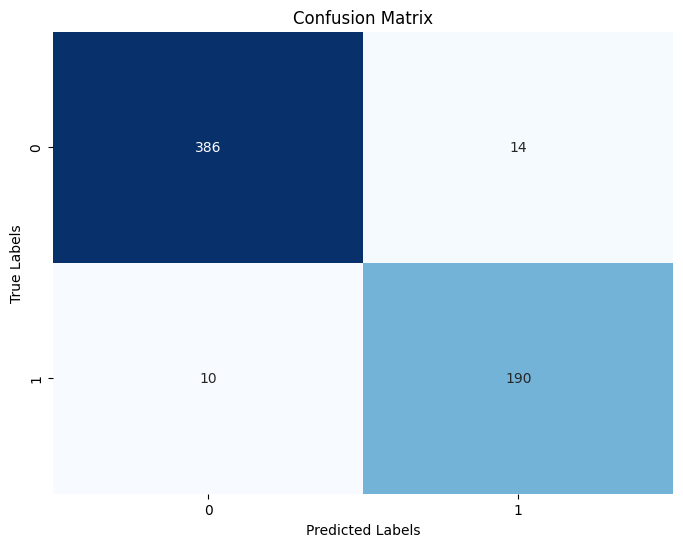

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred_1)
recall = recall_score(y_test, y_pred_1)
precision = precision_score(y_test, y_pred_1)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MistralAI 7B LLM performs well on our data. Our findings reveal that, in the majority of cases, LLMs surpass the performance of the popular baseline techniques, particularly in few-shot scenarios. This adaptability renders LLMs uniquely suited to spam detection tasks, where labeled samples are limited in number and models require frequent updates.